# Recurrent Neural Network

In this task, we implement RNN cells to understand the computation of RNN. Then we build RNN with different cells for a language modeling task.

In [1]:
# As usual, a bit of setup
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


## Recurrent Neural Networks

### A toy problem

In [2]:
## Setup an example. Provide sizes and the input data. 

# set sizes 
time_steps = 5
batch_size = 4
input_size = 3
hidden_size = 2

# create input data with shape [batch_size, time_steps, num_features]
np.random.seed(15009)
input_data = np.random.rand(batch_size, time_steps, input_size).astype(np.float32)

### Implement an RNN and a GRU with tensorflow

In [3]:
## Create an RNN model
tf.reset_default_graph()
tf.set_random_seed(15009)

# initialize a state of zero for both RNN and GRU
# 'state' is a tensor of shape [batch_size, hidden_size]
init_state = np.zeros([batch_size, hidden_size]) 
initial_state = tf.Variable(init_state, dtype=tf.float32)

# create a BasicRNNCell
rnn_cell = tf.nn.rnn_cell.BasicRNNCell(hidden_size)


# 'outputs' is a tensor of shape [batch_size, max_time, hidden_size]
# RNN cell outputs the hidden state directly, so the output at each step is the hidden state at that step
# final_state is the last state of the sequence. final_state == outputs[:, -1, :]
rnn_outputs, rnn_final_state = tf.nn.dynamic_rnn(rnn_cell, input_data,
                                   initial_state=initial_state,
                                   dtype=tf.float32)


# create a GRUCell
gru_cell = tf.nn.rnn_cell.GRUCell(hidden_size)

# 'outputs' is a tensor of shape [batch_size, time_steps, hidden_size]
# Same as the basic RNN cell, final_state == outputs[:, -1, :]
gru_outputs, gru_final_state = tf.nn.dynamic_rnn(gru_cell, input_data,
                                   initial_state=initial_state,
                                   dtype=tf.float32)



# initialize variables
init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)

# run the RNN model and get outputs and the final state
tfrnn_outputs, tfrnn_final_state = session.run([rnn_outputs, rnn_final_state])

# run the GRU model and get outputs and the final state
tfgru_outputs, tfgru_final_state = session.run([gru_outputs, gru_final_state])

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


### Read out parameters from RNN and GRU cells

In [4]:
from rnn_param_helper import get_rnn_params, get_gru_params

#################################################################################################
# 0. Understand TF BasicRNN and GRU parameters (0 points)                                       #
# Please read the code and documentation of get_rnn_params and get_gru_params to understand     #
# what are these parameters. You will need to use these parameters in your own implementations  #
# NO implementation is needed here.                                                             #
#################################################################################################

wt_h, wt_x, bias = get_rnn_params(rnn_cell, session)
wtu_h, wtu_x, biasu, wtr_h, wtr_x, biasr, wtc_h, wtc_x, biasc = get_gru_params(gru_cell, session)



### Numpy Implementation
Implement your own RNN model with numpy. Your implementation needs to match the tensorflow calculation. 

In [5]:
###############################################################################################
# 1. Implementation (9 points)                                                                #
# Implement your basic RNN and GRU RNN in implementations/rnn.py and compare them against the #
# tensorflow functions                                                                        #
###############################################################################################

from implementations.rnn import rnn,gru

# calculation from your own implemenation of a basic RNN
nprnn_outputs, nprnn_final_state = rnn(wt_h, wt_x, bias, init_state, input_data)

print("Difference between your RNN implementation and tf RNN", 
                     rel_error(tfrnn_outputs, nprnn_outputs) + rel_error(tfrnn_final_state, nprnn_final_state))

# calculation from your own implemenation of a GRU RNN
npgru_outputs, npgru_final_state = gru(wtu_h, wtu_x, biasu, wtr_h, wtr_x, biasr, wtc_h, wtc_x, biasc, init_state, input_data)

print("Difference between your GRU implementation and tf GRU", 
      rel_error(tfgru_outputs, npgru_outputs) + rel_error(tfgru_final_state, npgru_final_state))


Difference between your RNN implementation and tf RNN 2.0376387104263702e-07
Difference between your GRU implementation and tf GRU 6.114071923523539e-07


### GRU includes RNN as a special case
Can you assign a special set of parameters to GRU such that its outputs is almost the same as RNN?

In [6]:
gru_cell.weights

[<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(5, 4) dtype=float32_ref>,
 <tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(4,) dtype=float32_ref>,
 <tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(5, 2) dtype=float32_ref>,
 <tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(2,) dtype=float32_ref>]

In [7]:
print(np.shape(wt_h))
print(np.shape(wt_x))
print(np.shape(bias))

(2, 2)
(3, 2)
(2,)


In [8]:
gru_cell.get_weights()

for w in gru_cell.get_weights():
    print(np.shape(w))
    
for w in rnn_cell.get_weights():
    print(np.shape(w))

(5, 4)
(4,)
(5, 2)
(2,)
(5, 2)
(2,)


In [10]:
get_gru_params(gru_cell,session)

(array([[0.2570294 , 0.18042606],
        [0.55225396, 0.01041299]], dtype=float32),
 array([[-0.12779993, -0.5327523 ],
        [-0.39908138, -0.23855895],
        [ 0.489545  , -0.567869  ]], dtype=float32),
 array([1., 1.], dtype=float32),
 array([[-0.60442555,  0.03419924],
        [-0.70110077,  0.33259356]], dtype=float32),
 array([[-0.15348929,  0.44127274],
        [ 0.43770444,  0.23846614],
        [ 0.02737868, -0.28020447]], dtype=float32),
 array([1., 1.], dtype=float32),
 array([[ 0.21247792, -0.88683033],
        [-0.70402217, -0.7342076 ]], dtype=float32),
 array([[-0.27413416, -0.5402237 ],
        [-0.4862627 ,  0.39016676],
        [-0.38728678,  0.07803273]], dtype=float32),
 array([0., 0.], dtype=float32))

In [40]:
# Assign some value to a parameter of GRU

####################################################################################
# 2. Setting GRU weights (4 points)                                                #
# Get weights/bias from the basic RNN and set them to some GRU weights/bias        #
# Then set some other parameter of GRU, then GRU recovers RNN.                     #
####################################################################################

#session.run(gru_cell.weights[0].assign(np.zeros((5,4))))
#session.run(gru_cell.weights[1].assign(np.ones(4)))
#session.run(gru_cell.weights[2].assign(rnn_cell.get_weights()[0]))
#session.run(gru_cell.weights[3].assign(rnn_cell.get_weights()[1]))

set_gru_parms(gru_cell,session)

# outputs from the GRU with special parameters. 
updated_outputs = session.run(gru_outputs)

# they are the same as the calculation from the basic RNN
print("Difference between RNN and a special GRU", rel_error(tfrnn_outputs, updated_outputs))

Difference between RNN and a special GRU 1.0


## Long term dependency: forward

In this experiment, you will see that the basic RNN model is hard to keep long term dependency

/Users/alanzhou/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1712: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


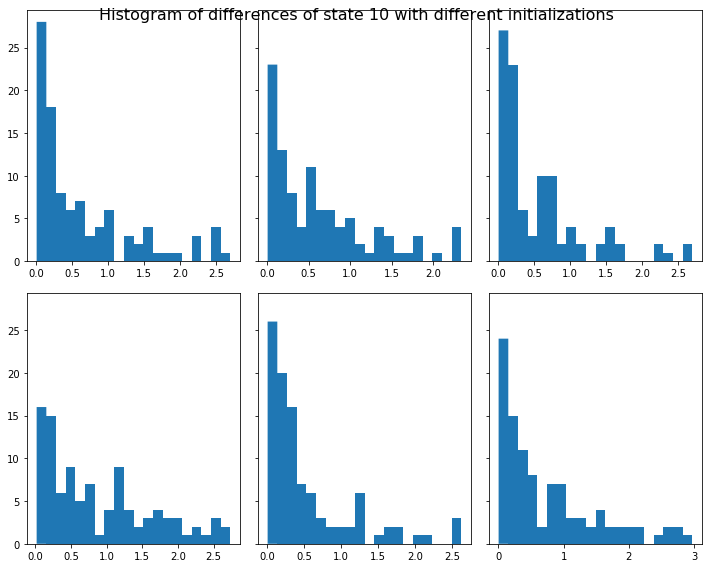

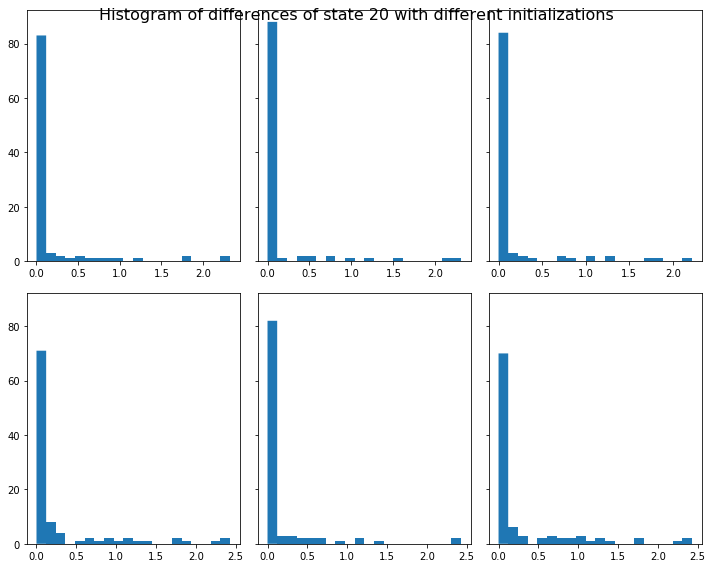

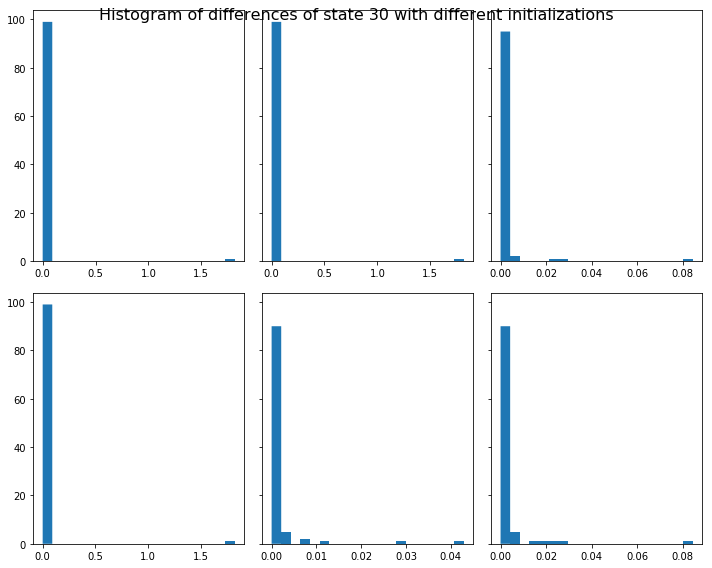

In [65]:
from rnn_param_helper import set_rnn_params, set_gru_params

# Create a larger problem

# set sizes 
time_steps = 50
batch_size = 100
input_size = 5
hidden_size = 8

# create input data with shape [batch_size, time_steps, num_features]
np.random.seed(15009)
input_data = np.random.rand(batch_size, time_steps, input_size).astype(np.float32) - 0.5

## Create an RNN model with GRU
tf.reset_default_graph()
tf.set_random_seed(15009)


# create a GRUCell
gru_cell = tf.nn.rnn_cell.GRUCell(hidden_size)
# create a BasicRNNCell
rnn_cell = tf.nn.rnn_cell.BasicRNNCell(hidden_size)

# copy the basic RNN and the GRU RNN above here: 

initial_state = tf.Variable(np.zeros([batch_size, hidden_size]), dtype=tf.float32)

###################################################################################################
# 3. Apply TF RNN functions (2 points)                                                            #
# Please use the tensorflow function for the basic RNN and the GRU RNN below to get their outputs #
# from the larger problem. Basically you just need to copy some code above here.                  #
###################################################################################################

rnn_outputs, _ = tf.nn.dynamic_rnn(rnn_cell, input_data, initial_state=initial_state, dtype = tf.float32)
gru_outputs, _ = tf.nn.dynamic_rnn(gru_cell,input_data,initial_state=initial_state, dtype=tf.float32) # please complete this line and lines above

# initialize variables
init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)



def show_hist_of_hidden_values(session, initial_state, state, title):
    """Set `initial_state` to different values and run the `state` value. Check differences between state  
       values due to different initializations. If the model cannot capture long term dependency, then the 
       initialization does not have much effect to the value of `state` at a later time step. 
    """
    
    batch_size, hiddens_size = state.get_shape()
    
    # intialize the model with different initial states and then calculate the final state
    init_zero = np.zeros([batch_size, hidden_size])
    session.run(initial_state.assign(init_zero))
    state_zero_init = session.run(state)

    init_rand1 = np.random.rand(batch_size, hidden_size)
    session.run(initial_state.assign(init_rand1))
    state_rand1_init = session.run(state)

    init_rand2 = np.random.rand(batch_size, hidden_size)
    session.run(initial_state.assign(init_rand2))
    state_rand2_init = session.run(state)

    init_scaleup1 = init_rand1 * 100
    session.run(initial_state.assign(init_scaleup1))
    state_scaleup1_init = session.run(state)

    # plot the difference between the four difference settings
    
    # For each sequence, calculate the norm of the difference of the states from different initializations
    norm_diff1 = np.linalg.norm(state_zero_init - state_rand1_init, axis=1)
    norm_diff2 = np.linalg.norm(state_zero_init - state_rand2_init, axis=1)
    norm_diff3 = np.linalg.norm(state_rand1_init - state_rand2_init, axis=1)
    norm_diff4 = np.linalg.norm(state_scaleup1_init - state_zero_init, axis=1)
    norm_diff5 = np.linalg.norm(state_scaleup1_init - state_rand1_init, axis=1)
    norm_diff6 = np.linalg.norm(state_scaleup1_init - state_rand2_init, axis=1)

    # plot the histogram of norms of differences
    n_bins = 20
    fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True)
    plt.suptitle(title, fontsize=16)
    
    axs[0, 0].hist(norm_diff1, bins=n_bins)
    axs[0, 1].hist(norm_diff2, bins=n_bins)
    axs[0, 2].hist(norm_diff3, bins=n_bins)
    axs[1, 0].hist(norm_diff4, bins=n_bins)
    axs[1, 1].hist(norm_diff5, bins=n_bins)
    axs[1, 2].hist(norm_diff6, bins=n_bins)
    
    

    
# set values for the basic RNN model

# play with the scale, and see if you can find any value that achieves long-term memory
scale = 2.0
wt_h = (np.random.rand(hidden_size, hidden_size) - 0.5) * scale
wt_x = (np.random.rand(input_size, hidden_size) - 0.5) * scale
bias = (np.random.rand(hidden_size) - 0.5) * scale

set_rnn_params(rnn_cell, session, wt_h, wt_x, bias)

# get the 10th state and check its dependency on the initial state
rnn_state10 = tf.transpose(rnn_outputs, [1, 0, 2])[10]
show_hist_of_hidden_values(session, initial_state, rnn_state10, 
                           'Histogram of differences of state 10 with different initializations')

# get the 20th state and check its dependency on the initial state
rnn_state20 = tf.transpose(rnn_outputs, [1, 0, 2])[20]
show_hist_of_hidden_values(session, initial_state, rnn_state20, 
                           'Histogram of differences of state 20 with different initializations')

# get the 20th state and check its dependency on the initial state
rnn_state30 = tf.transpose(rnn_outputs, [1, 0, 2])[30]
show_hist_of_hidden_values(session, initial_state, rnn_state30, 
                           'Histogram of differences of state 30 with different initializations')


/Users/alanzhou/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1712: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


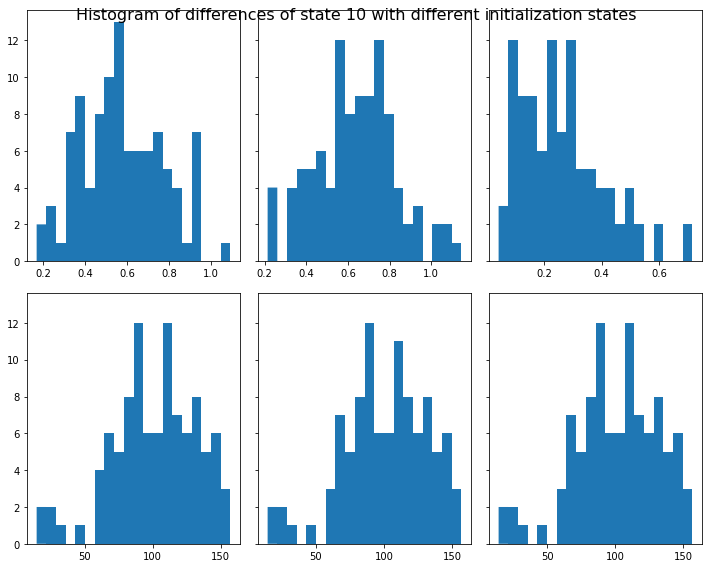

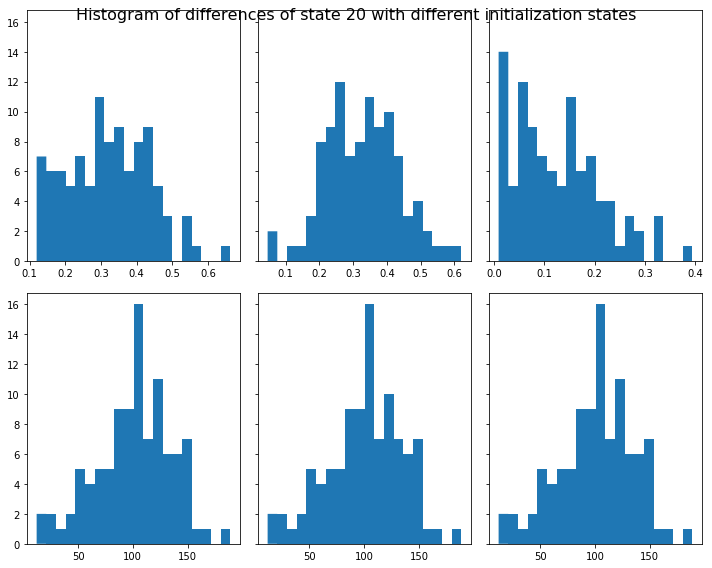

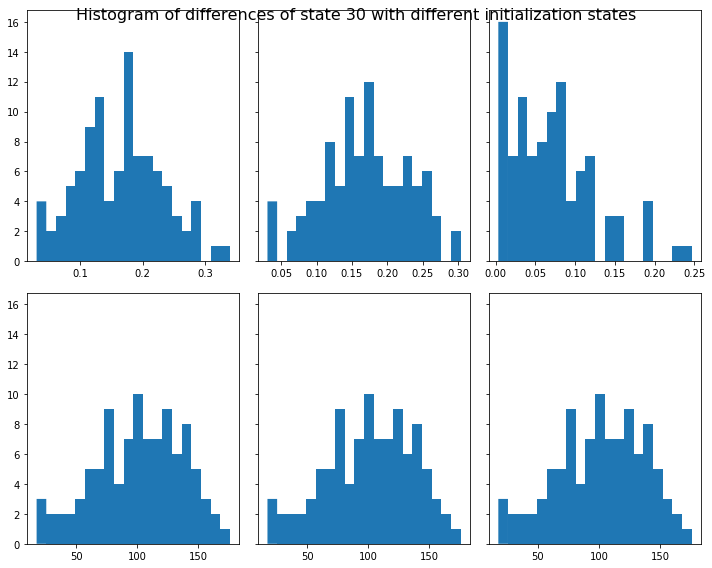

In [69]:
# Can you set GRU parameters such that it maintains the initial state in the memory for long term? 

scale_gru = 5.0

#########################################################################
# 4. Setting GRU parameters (4 points)                                  #
# Set GRU parameters here so that it can capture long term dependency   #
#########################################################################

# get the 10th state
gru_state10 = tf.transpose(gru_outputs, [1, 0, 2])[10]
show_hist_of_hidden_values(session, initial_state, gru_state10,
                           'Histogram of differences of state 10 with different initialization states')

# get the 20th state
gru_state20 = tf.transpose(gru_outputs, [1, 0, 2])[20]
show_hist_of_hidden_values(session, initial_state, gru_state20,
                           'Histogram of differences of state 20 with different initialization states')

# get the 20th state
gru_state30 = tf.transpose(gru_outputs, [1, 0, 2])[30]
show_hist_of_hidden_values(session, initial_state, gru_state30,
                           'Histogram of differences of state 30 with different initialization states')



### Backpropagation: vanishing gradients and exploding gradients

In the experiment, you will observe vanishing gradients and exploding gradients

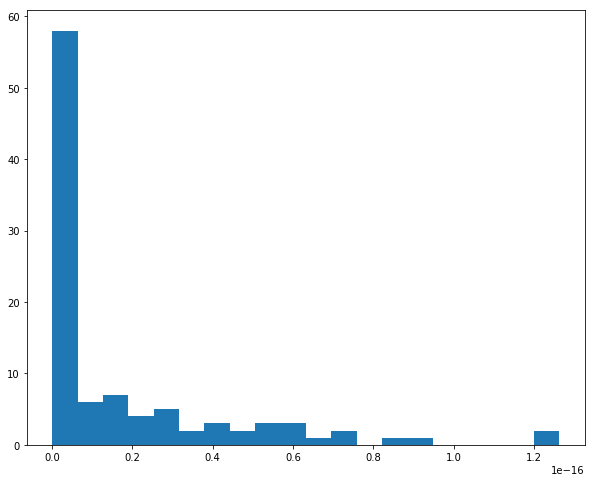

In [372]:
# Calculate gradient with respect to the initial state

# the gradient with respect to state 30 is [1, 1, ..., 1]. Propagate the gradient back through time
rnn_loss30 = tf.reduce_sum(rnn_state30)
rnn_gradh = tf.gradients([rnn_loss30], [initial_state])[0]

scale = 1.0
wt_h = (np.random.rand(hidden_size, hidden_size) - 0.5) * scale
wt_x = (np.random.rand(input_size, hidden_size) - 0.5) * scale
bias = (np.random.rand(hidden_size) - 0.5) * scale
set_rnn_params(rnn_cell, session, wt_h, wt_x, bias)


###############################################################################################
# 5. Observe vanishing gradients (3 points)                                                   #
# Try a different settings of the parameters and see if you still get vanishing gradients. ,  #
###############################################################################################


# show the norms of gradients. Most of them are zero. 
np_rnn_gradh = session.run(rnn_gradh)
rnn_grad_norm = np.linalg.norm(np_rnn_gradh, axis=1)

n_bins = 20
_ = plt.hist(rnn_grad_norm, bins=n_bins)



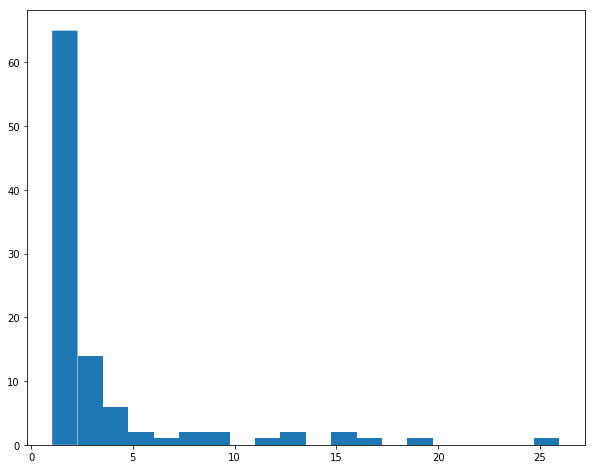

In [72]:
# Can you set GRU parameters such that the gradient does not vanish? 

# the gradient with respect to state 30 is [1, 1, ..., 1]. Propagate the gradient back through time
gru_loss30 = tf.reduce_sum(gru_state30)
gru_gradh = tf.gradients([gru_loss30], [initial_state])[0]



###################################################################################
# 6. GRU parameters that don't have vanishing gradients (3 points)                #
# Set GRU parameters so that the gradient of a later state with respect to the    #
# initial state is not near zero.                                                 #
###################################################################################

# show norms of gradients
np_gru_gradh = session.run(gru_gradh)
gru_grad_norm = np.linalg.norm(np_gru_gradh, axis=1)

n_bins = 20
_ = plt.hist(gru_grad_norm, bins=n_bins)


